In [1]:
from typing import List
from typing import Tuple
import torch.nn as nn
import numpy as np
import pandas as pd
import math
import torch
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [2]:
def create_binary_list_from_int(number: int) -> List[int]:
    if number < 0 or type(number) is not int:
        raise ValueError("Only Positive integers are allowed")

    return [int(x) for x in list(bin(number))[2:]]
    

In [3]:
def generate_even_data(max_int: int, batch_size: int=16) -> Tuple[List[int], List[List[int]]]:
    # Get the number of binary places needed to represent the maximum number
    max_length = int(math.log(max_int, 2))

    # Sample batch_size number of integers in range 0-max_int
    sampled_integers = np.random.randint(0, int(max_int / 2), batch_size)

    # create a list of labels all ones because all numbers are even
    labels = [1] * batch_size

    # Generate a list of binary numbers for training.
    data = [create_binary_list_from_int(int(x * 2)) for x in sampled_integers]
    data = [([0] * (max_length - len(x))) + x for x in data]

    return labels, data

### Create Generator

In [4]:
class Generator(nn.Module):

    def __init__(self, input_length: int):
        super().__init__()
        self.layer  = nn.Sequential(
            nn.Linear(input_length, input_length),
            nn.Sigmoid()
            )
    def forward(self,xb):
        return self.layer(xb)

    

### Create Discriminator

In [5]:
class Discriminator(nn.Module):

    def __init__(self, input_length: int):
        super().__init__()
        self.layer  = nn.Sequential(
            nn.Linear(input_length, 1),
            nn.Sigmoid()
            )
    def forward(self,xb):
        return self.layer(xb)

In [6]:
# Input length is 128 because our dataset is numbers between 0 and 128
input_length = int(math.log(128, 2))

In [7]:
generator = Generator(input_length)
discriminator = Discriminator(input_length)

In [8]:
num_epochs = 200

### Training the Model 

In [10]:
def train(max_int: int = 128, batch_size: int = 16, training_steps: int = num_epochs):
    input_length = int(math.log(max_int, 2))

    # Models
    

    # Optimizers
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001)
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)

    # loss
    loss = nn.BCELoss()
    g_loss_vals = []
    d_loss_vals = []
    for i in range(training_steps):
       
        # zero the gradients on each iteration
        generator_optimizer.zero_grad()

        # Create noisy input for generator
        # Need float type instead of int
        noise = torch.randint(0, 2, size=(batch_size, input_length)).float()
        generated_data = generator(noise)
         
        print("generated_data:", generated_data)    
        # Generate examples of even real data
        true_labels, true_data = generate_even_data(max_int, batch_size=batch_size)
        true_labels = torch.tensor(true_labels).float()
        true_data = torch.tensor(true_data).float()

        # Train the generator
        # We invert the labels here and don't train the discriminator because we want the generator
        # to make things the discriminator classifies as true.
     #  Get the predictions from the discriminator on the “fake” data
        generator_discriminator_out = discriminator(generated_data)

        true_labels = true_labels.reshape((len(true_labels), 1))
        generator_loss = loss(generator_discriminator_out, true_labels)
        g_loss_vals.append(generator_loss.item())
        generator_loss.backward()
        generator_optimizer.step()

        # Train the discriminator on the true/generated data
        discriminator_optimizer.zero_grad()
        true_discriminator_out = discriminator(true_data)
        
#         print('true_discriminator_out',true_discriminator_out.shape)
#         print('true_labels',true_labels.shape)
        true_discriminator_loss = loss(true_discriminator_out, true_labels)
        true_discriminator_loss.backward()
        # add .detach() here think about this
        generator_discriminator_out = discriminator(generated_data.detach())
        fake_data = torch.zeros(batch_size)
        fake_data = fake_data.reshape(len(fake_data),1)
        generator_discriminator_loss = loss(generator_discriminator_out, fake_data)
        discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
        d_loss_vals.append(discriminator_loss.item())
#         discriminator_loss.backward()
        generator_discriminator_loss.backward()
        discriminator_optimizer.step()
    return g_loss_vals,d_loss_vals
#         return generator,discriminator

In [11]:
generator_loss, discriminator_loss = train()

generated_data: tensor([[0.6211, 0.5981, 0.5449, 0.3710, 0.4403, 0.5244, 0.2530],
        [0.4957, 0.5968, 0.5515, 0.4245, 0.3249, 0.4289, 0.3677],
        [0.5708, 0.5936, 0.5360, 0.4177, 0.5004, 0.5939, 0.2696],
        [0.6326, 0.6184, 0.6163, 0.3891, 0.4732, 0.6287, 0.2575],
        [0.5747, 0.6364, 0.5155, 0.5102, 0.4720, 0.5888, 0.3212],
        [0.4579, 0.5767, 0.6257, 0.4834, 0.4067, 0.5116, 0.3768],
        [0.5530, 0.5917, 0.5561, 0.3737, 0.4484, 0.5517, 0.3060],
        [0.5846, 0.5324, 0.5512, 0.3423, 0.4634, 0.5545, 0.2891],
        [0.5567, 0.5908, 0.4654, 0.3760, 0.3586, 0.4936, 0.3949],
        [0.4579, 0.5767, 0.6257, 0.4834, 0.4067, 0.5116, 0.3768],
        [0.5279, 0.5376, 0.5466, 0.3915, 0.3383, 0.4317, 0.3491],
        [0.5569, 0.6346, 0.5357, 0.4642, 0.4205, 0.5465, 0.3612],
        [0.6644, 0.6506, 0.4436, 0.3991, 0.5146, 0.6272, 0.2566],
        [0.6475, 0.5405, 0.5785, 0.4613, 0.5354, 0.6922, 0.2918],
        [0.5030, 0.5506, 0.5593, 0.4121, 0.5034, 0.5279, 0.3

       grad_fn=<SigmoidBackward>)
generated_data: tensor([[0.7183, 0.5143, 0.5457, 0.4479, 0.5881, 0.6268, 0.1804],
        [0.6123, 0.5143, 0.4219, 0.4395, 0.6230, 0.6028, 0.2696],
        [0.4528, 0.5727, 0.5342, 0.5236, 0.4995, 0.5338, 0.4118],
        [0.6554, 0.5725, 0.4078, 0.4787, 0.6088, 0.5654, 0.2293],
        [0.6123, 0.5143, 0.4219, 0.4395, 0.6230, 0.6028, 0.2696],
        [0.5029, 0.5149, 0.5093, 0.5354, 0.5664, 0.5793, 0.3508],
        [0.5075, 0.5474, 0.5764, 0.5612, 0.4897, 0.5231, 0.3079],
        [0.7190, 0.5532, 0.5300, 0.4686, 0.4118, 0.5221, 0.2166],
        [0.6199, 0.4688, 0.5634, 0.4532, 0.4650, 0.5525, 0.2712],
        [0.6389, 0.5334, 0.5766, 0.4389, 0.3915, 0.4789, 0.2701],
        [0.5435, 0.5917, 0.5873, 0.5482, 0.5328, 0.6038, 0.3474],
        [0.6719, 0.5398, 0.5032, 0.4108, 0.5975, 0.6369, 0.2572],
        [0.6363, 0.5470, 0.4785, 0.5088, 0.5198, 0.5599, 0.2767],
        [0.5882, 0.5592, 0.4338, 0.4071, 0.3891, 0.4615, 0.3640],
        [0.6595, 0.6041, 0

       grad_fn=<SigmoidBackward>)
generated_data: tensor([[0.6920, 0.5061, 0.6026, 0.5084, 0.4727, 0.5379, 0.2351],
        [0.6177, 0.5276, 0.4044, 0.4397, 0.4207, 0.4305, 0.3325],
        [0.5498, 0.5795, 0.3525, 0.4752, 0.5421, 0.4179, 0.3064],
        [0.6287, 0.5129, 0.4790, 0.4533, 0.5294, 0.4727, 0.2396],
        [0.7199, 0.4940, 0.4593, 0.4234, 0.4614, 0.5114, 0.2646],
        [0.6824, 0.5315, 0.5004, 0.5845, 0.4923, 0.4558, 0.2034],
        [0.6345, 0.5265, 0.5913, 0.6258, 0.5643, 0.5543, 0.2210],
        [0.5910, 0.5204, 0.4547, 0.5515, 0.4504, 0.3943, 0.2583],
        [0.6442, 0.5454, 0.3309, 0.4184, 0.5188, 0.4282, 0.2724],
        [0.7484, 0.4665, 0.5224, 0.4157, 0.4009, 0.4577, 0.2142],
        [0.7060, 0.5036, 0.3554, 0.4725, 0.5256, 0.4022, 0.1815],
        [0.7355, 0.5111, 0.5122, 0.4652, 0.4016, 0.4395, 0.2167],
        [0.6899, 0.5194, 0.5050, 0.5783, 0.6016, 0.6166, 0.2409],
        [0.6522, 0.5457, 0.5362, 0.5226, 0.4243, 0.4292, 0.2461],
        [0.6515, 0.5001, 0

generated_data: tensor([[0.7411, 0.5027, 0.3817, 0.6113, 0.6351, 0.4091, 0.1345],
        [0.6247, 0.4688, 0.5347, 0.5030, 0.4576, 0.4496, 0.2712],
        [0.7159, 0.4988, 0.3436, 0.5566, 0.6780, 0.4930, 0.1766],
        [0.5675, 0.4834, 0.4959, 0.4814, 0.5715, 0.4616, 0.2510],
        [0.6617, 0.4609, 0.3601, 0.5149, 0.5811, 0.3793, 0.1817],
        [0.7858, 0.4956, 0.3033, 0.5633, 0.6698, 0.4724, 0.1481],
        [0.6779, 0.5253, 0.4080, 0.6262, 0.5874, 0.4768, 0.2245],
        [0.7574, 0.5165, 0.3397, 0.4940, 0.6002, 0.4519, 0.1864],
        [0.4804, 0.5439, 0.5074, 0.5542, 0.5293, 0.5053, 0.3807],
        [0.6917, 0.4594, 0.4090, 0.5575, 0.6346, 0.4615, 0.1710],
        [0.7873, 0.4824, 0.3929, 0.4931, 0.5464, 0.3933, 0.1442],
        [0.8130, 0.4616, 0.3538, 0.5624, 0.6194, 0.4132, 0.1134],
        [0.7007, 0.4220, 0.4247, 0.5005, 0.6276, 0.4863, 0.1732],
        [0.7198, 0.4803, 0.4481, 0.4729, 0.6543, 0.5811, 0.2103],
        [0.7060, 0.4916, 0.2711, 0.5226, 0.6249, 0.4171, 0.1

generated_data: tensor([[0.5860, 0.4720, 0.3792, 0.5772, 0.7119, 0.5185, 0.2356],
        [0.7952, 0.3932, 0.4584, 0.4945, 0.4745, 0.3873, 0.1618],
        [0.7061, 0.4867, 0.3573, 0.5220, 0.6392, 0.4412, 0.1951],
        [0.6048, 0.4780, 0.4572, 0.5301, 0.5368, 0.4857, 0.3105],
        [0.7090, 0.4444, 0.5125, 0.5137, 0.5777, 0.5661, 0.2454],
        [0.7929, 0.4218, 0.4357, 0.5601, 0.4900, 0.3568, 0.1546],
        [0.6060, 0.5231, 0.5263, 0.6190, 0.6012, 0.5375, 0.2801],
        [0.7483, 0.4029, 0.5625, 0.5218, 0.5316, 0.4984, 0.1870],
        [0.6458, 0.4915, 0.2684, 0.6144, 0.6766, 0.3755, 0.1969],
        [0.6707, 0.4834, 0.4449, 0.5282, 0.5298, 0.4574, 0.2563],
        [0.5361, 0.5306, 0.4036, 0.5652, 0.6535, 0.4732, 0.2856],
        [0.7609, 0.4344, 0.4090, 0.4865, 0.5212, 0.4536, 0.2144],
        [0.8223, 0.3938, 0.3888, 0.6351, 0.5726, 0.3685, 0.1179],
        [0.7775, 0.4450, 0.3382, 0.6673, 0.6856, 0.3569, 0.1061],
        [0.6513, 0.4358, 0.5074, 0.5381, 0.4901, 0.4183, 0.2

generated_data: tensor([[0.5054, 0.5144, 0.4842, 0.5842, 0.5577, 0.4777, 0.3478],
        [0.6011, 0.4529, 0.3659, 0.5963, 0.7266, 0.5008, 0.2189],
        [0.7294, 0.4517, 0.3535, 0.6944, 0.6543, 0.4085, 0.1692],
        [0.7301, 0.4156, 0.4752, 0.5629, 0.5085, 0.3683, 0.1765],
        [0.7636, 0.3785, 0.5432, 0.5481, 0.5562, 0.4746, 0.1686],
        [0.6193, 0.4805, 0.5393, 0.5683, 0.5982, 0.5580, 0.2781],
        [0.7652, 0.4125, 0.3813, 0.5633, 0.6249, 0.3479, 0.1274],
        [0.7693, 0.3818, 0.4227, 0.6435, 0.5963, 0.3747, 0.1319],
        [0.7652, 0.4125, 0.3813, 0.5633, 0.6249, 0.3479, 0.1274],
        [0.8007, 0.3788, 0.3326, 0.6438, 0.7040, 0.3541, 0.0938],
        [0.7315, 0.4383, 0.4477, 0.6323, 0.5301, 0.3332, 0.1645],
        [0.7587, 0.4451, 0.3767, 0.6047, 0.7212, 0.4879, 0.1562],
        [0.5500, 0.4880, 0.4164, 0.5131, 0.6505, 0.4940, 0.2833],
        [0.6673, 0.4455, 0.4862, 0.6485, 0.6800, 0.5647, 0.2145],
        [0.8065, 0.4060, 0.3034, 0.5138, 0.6596, 0.4083, 0.1

generated_data: tensor([[0.8192, 0.3312, 0.4371, 0.7270, 0.6932, 0.4104, 0.0970],
        [0.7442, 0.4027, 0.3629, 0.6548, 0.6572, 0.4237, 0.1616],
        [0.7724, 0.3962, 0.3863, 0.5612, 0.7237, 0.5033, 0.1490],
        [0.7915, 0.3662, 0.3716, 0.7388, 0.6511, 0.3100, 0.1020],
        [0.8188, 0.3028, 0.2545, 0.5963, 0.6794, 0.2804, 0.0887],
        [0.7850, 0.3667, 0.2032, 0.6502, 0.7308, 0.3100, 0.1153],
        [0.6347, 0.4509, 0.3042, 0.5137, 0.6211, 0.3615, 0.2240],
        [0.6185, 0.4197, 0.4482, 0.5481, 0.6305, 0.4042, 0.1961],
        [0.8198, 0.3417, 0.3099, 0.6802, 0.7340, 0.3236, 0.0775],
        [0.8292, 0.3599, 0.2948, 0.6987, 0.6846, 0.3674, 0.1128],
        [0.6461, 0.4360, 0.3139, 0.6690, 0.6186, 0.3481, 0.2108],
        [0.6291, 0.4669, 0.5304, 0.5817, 0.6102, 0.5464, 0.2640],
        [0.7283, 0.3888, 0.2866, 0.6623, 0.7643, 0.4251, 0.1424],
        [0.7805, 0.3513, 0.2245, 0.5758, 0.7086, 0.3486, 0.1279],
        [0.7510, 0.4060, 0.4266, 0.6627, 0.5606, 0.3090, 0.1

## After Training check if generator is able to produce even number

In [ ]:
# 0,2 because we want only 0 and 1
# 20 - 20 samples

# noise = torch.randint(0, 2, size=(20, input_length)).float()

In [28]:

# print(input_length)
noise = torch.randint(0, 2, size=(20, input_length)).float()

print('** Generator input***')
print(noise)

# generator = Generator(input_length)
generated_data = generator(noise)
print('*** Generator output even number because last digit is 1 ***')
print(generated_data.round())


** Generator input***
tensor([[1., 1., 1., 1., 0., 0., 0.],
        [1., 0., 0., 1., 1., 1., 0.],
        [0., 0., 1., 1., 0., 1., 0.],
        [1., 1., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [1., 1., 0., 0., 1., 1., 1.],
        [1., 0., 0., 0., 1., 1., 1.],
        [0., 0., 1., 1., 1., 0., 0.],
        [0., 1., 1., 0., 1., 0., 1.],
        [1., 1., 1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 1., 1.],
        [1., 0., 0., 1., 1., 0., 0.],
        [0., 1., 1., 0., 1., 1., 0.],
        [0., 1., 1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 1., 0., 1.],
        [0., 1., 1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1., 0., 0.],
        [0., 1., 0., 1., 1., 1., 0.],
        [0., 1., 0., 0., 0., 1., 1.],
        [0., 1., 1., 0., 0., 0., 1.]])
*** Generator output even number because last digit is 1 ***
tensor([[0., 0., 1., 1., 0., 0., 1.],
        [0., 0., 1., 1., 0., 0., 1.],
        [0., 0., 1., 1., 0., 0., 1.],
        [1., 0., 1., 1., 0., 0., 1.],
    

In [24]:
epochs = np.linspace(0, num_epochs-1, num_epochs).astype(int)

In [25]:
print(len(epochs))
print(len(generator_loss))

200
200


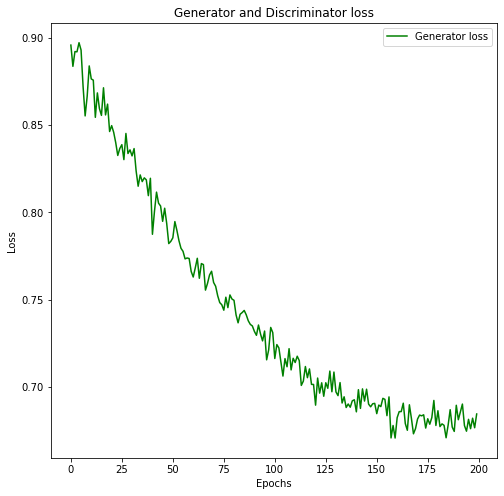

In [27]:
plt.figure(figsize=(8,8))
plt.plot(epochs, generator_loss,color = 'g',label = 'Generator loss')
# plt.plot(epochs, discriminator_loss,color = 'r',label = 'Discriminator loss')
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator and Discriminator loss")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()

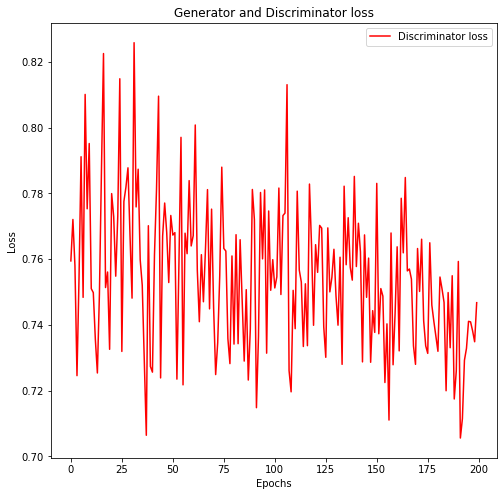

In [29]:
plt.figure(figsize=(8,8))
plt.plot(epochs, discriminator_loss,color = 'r',label = 'Discriminator loss')
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Generator and Discriminator loss")
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()